# Utilizar a rede Siamesa para classificação
* Escolher 1 a 5 imagens para comparação
* Estabelecer uma métrica para decidir qual classe correta

In [1]:
import numpy as np
import os
import random
import tensorflow as tf
import time

from collections import Counter
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


caminho_bases = os.path.join('..', 'bases', 'chest_xray')
caminho_train = os.path.join(caminho_bases, 'train')
caminho_test = os.path.join(caminho_bases, 'test')

SIZE = (224, 224)

# Carrega imagens

In [40]:
BATCH_SIZE = 512
datagen = ImageDataGenerator(
    rescale=1./255,
)
train_generator = datagen.flow_from_directory(
    caminho_train,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
validation_generator = datagen.flow_from_directory(
    caminho_test,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Models

In [41]:
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, \
    BatchNormalization, concatenate, Dense, Dropout, Flatten, Input, MaxPooling2D


SIZE = (224, 224)


nuclear_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3, 3),
                         padding='same',
                         activation='relu',
                         input_shape=(*SIZE, 3)),
  MaxPooling2D(pool_size=(2, 2)),
  Conv2D(32, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.2),
  Conv2D(64, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(128, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(128, (3, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(256, (3, 3), activation='relu'),
  Flatten(),
  Dense(128, activation='relu'),
 
])

a_in = Input(shape=(*SIZE, 3))
b_in = Input(shape=(*SIZE, 3))

a_feat = nuclear_model(a_in)
b_feat = nuclear_model(b_in)

combined_features = concatenate([a_feat, b_feat], name = 'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = tf.keras.Model(inputs = [a_in, b_in], outputs = [combined_features], name = 'Similarity_Model')

In [42]:
MODEL_DIR = '../models/siamese'

epoch = 2
val_loss = 0.69

epoch = 3
val_loss = 0.80

similarity_model.load_weights(os.path.join(
    MODEL_DIR, 
    '04modelweights.{:02d}-{:.2f}.hdf5'.format(epoch, val_loss)
    )
)


# Imagens escolhidas para comparação

(224, 224)


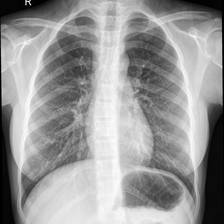

In [90]:
lista_normais = os.listdir(os.path.join(caminho_test, 'NORMAL'))

normal = Image.open(os.path.join(caminho_test, 'NORMAL', random.choice(lista_normais)))
normal = normal.resize(SIZE, Image.ANTIALIAS).convert('RGB')
print(normal.size)
normal

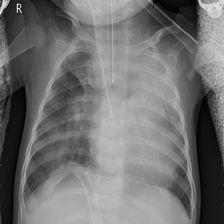

In [91]:
lista_pneumonia = os.listdir(os.path.join(caminho_test, 'PNEUMONIA'))
pneumonia = Image.open(os.path.join(caminho_test, 'PNEUMONIA',  random.choice(lista_pneumonia)))
pneumonia = pneumonia.resize(SIZE, Image.ANTIALIAS).convert('RGB')
pneumonia

# Montagem do batch

In [92]:
def monta_x1_batch(pil_image):
    x1 = np.zeros((BATCH_SIZE, *SIZE, 3), np.float32)
    img_array = np.array(pil_image) / 255
    for ind in range(BATCH_SIZE):
        x1[ind, :, :, :] = img_array
    return x1

def get_preds(generator, X_batch):
    generator.reset()
    y = []
    y_pred = []
    for r in range(len(validation_generator)):
        x2_batch, y_batch = next(validation_generator)
        pred_batch = similarity_model.predict([X_batch[:len(x2_batch)], x2_batch])
        y.extend(y_batch)
        y_pred.extend(list(pred_batch.reshape(-1)))
    return y, y_pred

def evaluate(pil_image, inverso=False):
    X_batch = monta_x1_batch(pil_image)
    y_test, y_pred = get_preds(validation_generator, X_batch)
    if inverso:
        y_labels = np.array(y_pred) > 0.5
    else:
        y_labels = np.array(y_pred) <= 0.5
    print(sum(y_labels == y_test) / len(y_labels))
    return y_test, y_pred 
    

In [93]:
%time y_test, y_predn = evaluate(normal, inverso=True)

0.375
CPU times: user 8.23 s, sys: 203 ms, total: 8.43 s
Wall time: 8.99 s


In [94]:
%time y_test, y_predp = evaluate(pneumonia)

0.625
CPU times: user 8.32 s, sys: 208 ms, total: 8.53 s
Wall time: 9.08 s


In [95]:
x1_batch_normal = monta_x1_batch(normal)
x1_batch_pneumonia = monta_x1_batch(pneumonia)
x2_batch, y_batch = next(validation_generator)
y_pred_normal = similarity_model.predict([x1_batch_normal, x2_batch])
y_pred_pneumonia = similarity_model.predict([x1_batch_pneumonia, x2_batch])

In [96]:
y_pred_normal

array([[0.292779  ],
       [0.30986696],
       [0.2962377 ],
       [0.29782784],
       [0.29132706],
       [0.2860002 ],
       [0.29378062],
       [0.29088205],
       [0.28810623],
       [0.30447698],
       [0.2916715 ],
       [0.3003301 ],
       [0.29664138],
       [0.30086523],
       [0.29087257],
       [0.30681318],
       [0.3685748 ],
       [0.3071711 ],
       [0.28357092],
       [0.29950774],
       [0.3228596 ],
       [0.29216436],
       [0.29906863],
       [0.28131145],
       [0.28445452],
       [0.28291273],
       [0.293634  ],
       [0.288802  ],
       [0.28014877],
       [0.30027604],
       [0.29803264],
       [0.29970413],
       [0.2925871 ],
       [0.28643608],
       [0.29238552],
       [0.28144133],
       [0.29038197],
       [0.32343733],
       [0.30604613],
       [0.29260665],
       [0.29221153],
       [0.29714262],
       [0.32161045],
       [0.27869645],
       [0.33171886],
       [0.293948  ],
       [0.28930128],
       [0.330

In [97]:
y_pred_pneumonia

array([[0.1976588 ],
       [0.21085027],
       [0.20031181],
       [0.19372663],
       [0.19654733],
       [0.19248289],
       [0.19842607],
       [0.19620699],
       [0.19408745],
       [0.20313549],
       [0.19681072],
       [0.19798645],
       [0.20062226],
       [0.19452462],
       [0.19344124],
       [0.19975767],
       [0.23575315],
       [0.2087552 ],
       [0.19063592],
       [0.20170578],
       [0.22102082],
       [0.1954056 ],
       [0.20248988],
       [0.18847951],
       [0.19130713],
       [0.19013593],
       [0.19831392],
       [0.19461843],
       [0.18804097],
       [0.20169696],
       [0.20169243],
       [0.20060238],
       [0.19235575],
       [0.19281474],
       [0.1971915 ],
       [0.18902007],
       [0.19582453],
       [0.22147569],
       [0.20788229],
       [0.1975267 ],
       [0.19405088],
       [0.2010077 ],
       [0.22003743],
       [0.18694201],
       [0.22802642],
       [0.19855455],
       [0.19055283],
       [0.226

In [100]:
y_labels = (y_pred_normal < y_pred_pneumonia)

In [101]:
sum(y_labels.reshape(-1) == y_batch) / len(y_labels)

0.45703125

In [102]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_batch, y_labels))
print(classification_report(y_batch, y_labels, digits=4))

[[234   0]
 [278   0]]
             precision    recall  f1-score   support

        0.0     0.4570    1.0000    0.6273       234
        1.0     0.0000    0.0000    0.0000       278

avg / total     0.2089    0.4570    0.2867       512



## A diferença entre comparar a imagem com exemplos de vazios e não vazios e checar qual a similaridade maior parece ser o método mais preciso, alcançando desempenho similar ao dos melhores classificadores treinados anteriormente

## É possível ajustar a sensibilidade mudando os exemplos comparados (por exemplo pegando contêineres não vazios com mais carga???) Testar!!

In [74]:
len(y_batch)

512

In [75]:
len(y_test)

624

In [76]:
y_batch

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [77]:
y_labels

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [